# Linear Regression

## Setup and Imports

In [15]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [16]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

In [17]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


In [18]:
columb["home_value"] = columb["home.value"]  # rename to avoid dot in name

## Model Definition

In [19]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=jnp.asarray(df.crime),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [20]:
loc += tb.lin("scale(area)*scale(income) + home_value")

### Build and plot model

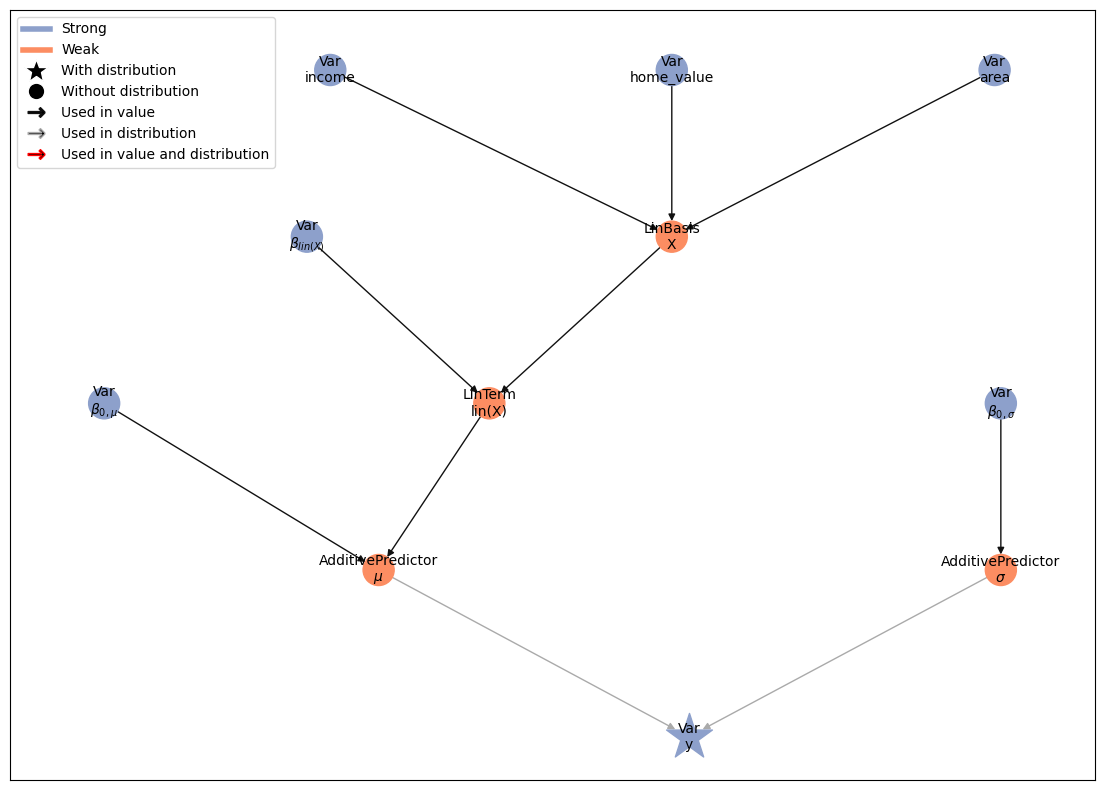

In [21]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [22]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{lin(X)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:01<00:00,  1.50chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:00<00:00, 28.62chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [23]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel       mean        sd     q_0.05  \
parameter          index                                              
$\beta_{0,\mu}$    ()     kernel_01  45.168083  4.306481  37.986240   
$\beta_{0,\sigma}$ ()     kernel_00   2.440114  0.107572   2.269603   
$\beta_{lin(X)}$   (0,)   kernel_02  -1.229358  1.933736  -4.421168   
                   (1,)   kernel_02  -9.461755  2.194437 -13.019721   
                   (2,)   kernel_02  -0.283356  0.104443  -0.450880   
                   (3,)   kernel_02   2.176025  1.810539  -0.805224   

                              q_0.5     q_0.95  sample_size     ess_bulk  \
parameter          index                                                   
$\beta_{0,\mu}$    ()     45.200794  52.141674         4000   964.351822   
$\beta_{0,\sigma}$ ()      2.437226   2.623628         4000  3693.103961   
$\beta_{lin(X)}$   (0,)   -1.231573   1.938254         4000  3818.219299   
                   (1,)   -9.468389  -5.776191         4000  2356.804011   
                   (2,)   -0.284451  -0.109921         4000   996.198295   
                   (3,)    2.175828   5.149729         4000  4195.878656   

                             ess_tail      rhat  
parameter          index                         
$\beta_{0,\mu}$    ()     1964.772417  1.003020  
$\beta_{0,\sigma}$ ()     3506.830514  0.999684  
$\beta_{lin(X)}$   (0,)   3799.333694  1.001289  
                   (1,)   3045.413130  1.000033  
                   (2,)   1906.267391  1.003044  
                   (3,)   3995.836869  1.000236

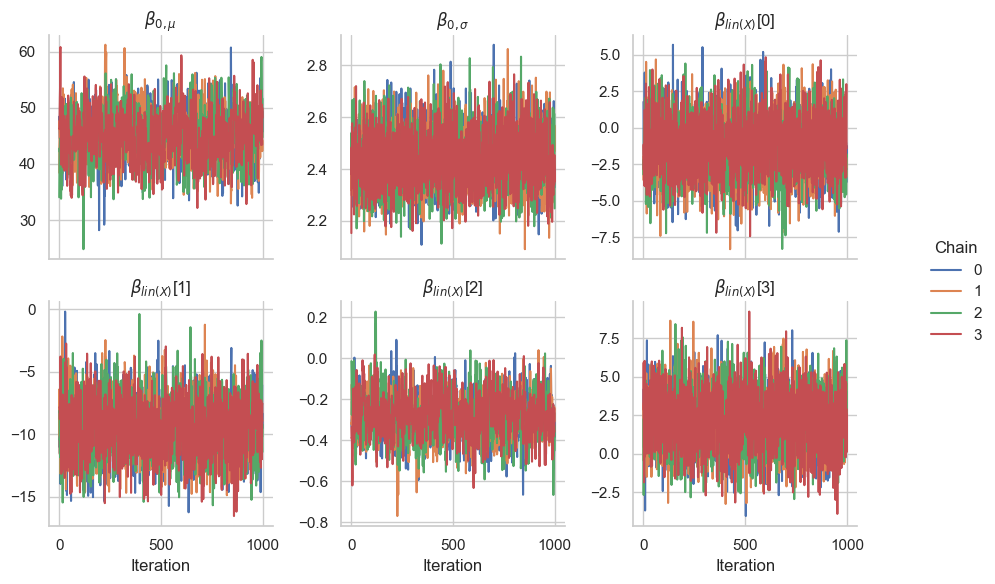

In [24]:
gs.plot_trace(results)

In [25]:
samples = results.get_posterior_samples()

In [26]:
gam.summarise_lin(model.vars["lin(X)"], samples)

,x,sample_size,mean,var,sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
0,scale(area),4000,-1.229358,3.739336,1.933736,-4.421168,-1.231573,1.938254,-4.427507,1.923644
1,scale(income),4000,-9.461755,4.815553,2.194437,-13.019721,-9.468389,-5.776191,-13.288948,-6.094583
2,home_value,4000,-0.283356,0.010908,0.104443,-0.450880,-0.284451,-0.109921,-0.451404,-0.110055
3,scale(area):scale(income),4000,2.176025,3.278051,1.810539,-0.805224,2.175828,5.149729,-0.862651,5.059187


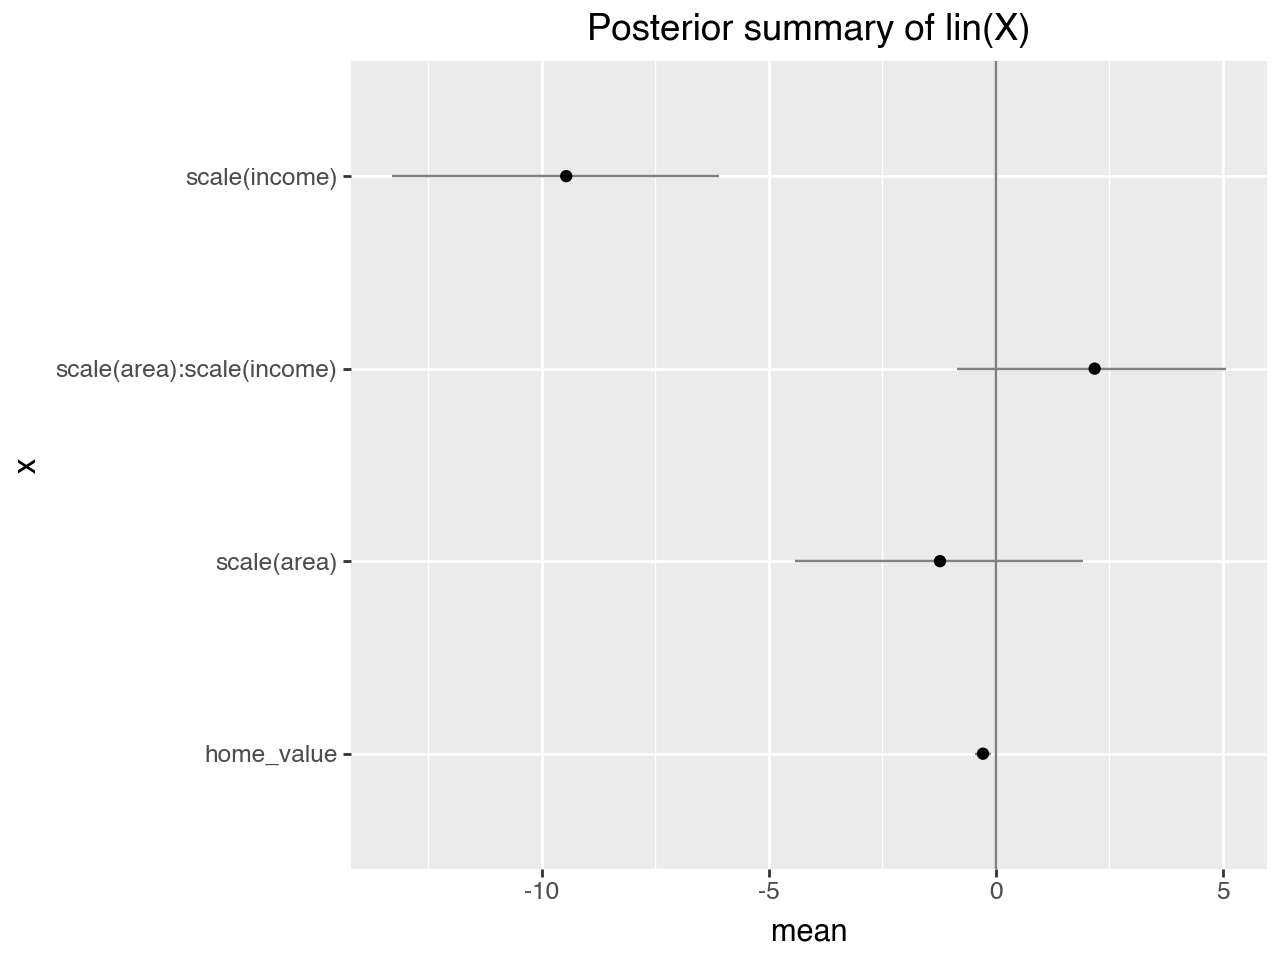

In [27]:
term = model.vars["lin(X)"]
gam.plot_forest(term, samples)